### Winning the company world cup cricket pool
... without following the actual games

I wanted to participate in the company world cup cricket mania without being left out because of my own ignorance towards the sport. 
So I decided to fight the battle in my own battlefield.

The constraints I had for myself were simple:
1. Don't spend a lot of time. Maximum of 1 day end to end. This ruled out any massive model building using play by play stats, players stats, team dynamics etc.
2. Encode the zeitgeist and perception of the sports fans and enthusiasts rather than focus on micro indicators.

Here's how I went about winning the pool (shared it with two other folks).

In [1]:
import sys
import threading
import numpy as np
import pandas as pd
import psycopg2 as pgres
import joblib
import os
import pdb
import argparse
import xgboost
from IPython.display import display_html
from lxml import html
import requests
from bs4 import BeautifulSoup
from xgboost import XGBClassifier as xgb
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Normalizer

/home/sridhar/PE_CSV/malenv3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Find the needed data
We need to find some data for all the international cricket matches for the last 2 decades. A simple google search would give bunch of such websites. Pick one and scrape the data to build a training set.

In [2]:
page = requests.get('http://howstat.com.au/cricket/Statistics/Matches/MatchList_ODI.asp?Group=2000010120191231&Range=2000')
soup = BeautifulSoup(page.content)
table = soup.find("table", attrs={"class":"TableLined"})

for a in table.findAll('a'):
    a.replaceWithChildren()
for a in table.findAll('span'):
    a.replaceWithChildren()
    
for a in soup.findAll('tr'):
    del a['bgcolor']

for a in soup.findAll('td'):
    del a['align']    

In [10]:
file = open('/tmp/test.txt', 'w')
file.write(str(table))

773741

Let's read the table into a pandas dataframe to make our lives easier

In [32]:
dfs = pd.read_html(str(table))
df = dfs[0]
df.head()

,0,1,2,3,4,5
0,NaN,Date,Countries,Ground,Result,&nbsp
1,1.0,02/01/2000,New Zealand v. West Indies,Eden Park,New Zealand won by 3 wickets,Scorecard
2,2.0,04/01/2000,New Zealand v. West Indies,Owen Delany Park,New Zealand won by 7 wickets,Scorecard
3,3.0,06/01/2000,New Zealand v. West Indies,McLean Park,New Zealand won by 4 wickets,Scorecard
4,4.0,08/01/2000,New Zealand v. West Indies,Westpac Stadium,New Zealand won by 8 wickets,Scorecard


We need to clean this up a bit

In [33]:
del df[0]
del df[5]
header = df.iloc[0]
df = df[1:]
df = df.rename(columns = header)
df.head()

,Date,Countries,Ground,Result
1,02/01/2000,New Zealand v. West Indies,Eden Park,New Zealand won by 3 wickets
2,04/01/2000,New Zealand v. West Indies,Owen Delany Park,New Zealand won by 7 wickets
3,06/01/2000,New Zealand v. West Indies,McLean Park,New Zealand won by 4 wickets
4,08/01/2000,New Zealand v. West Indies,Westpac Stadium,New Zealand won by 8 wickets
5,09/01/2000,Australia v. Pakistan,Brisbane Cricket Ground,Pakistan won by 45 runs


We'll separate out the countries

In [34]:
new = df["Countries"].str.split(" v. ", n = 1, expand = True) 
df['Team_A'] = new[0]
df['Team_B'] = new[1]
del df["Countries"]
df.head()

,Date,Ground,Result,Team_A,Team_B
1,02/01/2000,Eden Park,New Zealand won by 3 wickets,New Zealand,West Indies
2,04/01/2000,Owen Delany Park,New Zealand won by 7 wickets,New Zealand,West Indies
3,06/01/2000,McLean Park,New Zealand won by 4 wickets,New Zealand,West Indies
4,08/01/2000,Westpac Stadium,New Zealand won by 8 wickets,New Zealand,West Indies
5,09/01/2000,Brisbane Cricket Ground,Pakistan won by 45 runs,Australia,Pakistan


Now we get rid of all the matches that didn't yeild a winner and create a separate column for the winner. This would later be used as label for classification

In [35]:
df = df[df['Result'] != "Match abandoned"]
df = df[df['Result'] != "No Result"]
df = df[df['Result'] != "Match Tied" ]
    

In [36]:
res = df["Result"].str.split(" won ", n = 1, expand = True)
df['Winner'] = res[0]
df.head()

,Date,Ground,Result,Team_A,Team_B,Winner
1,02/01/2000,Eden Park,New Zealand won by 3 wickets,New Zealand,West Indies,New Zealand
2,04/01/2000,Owen Delany Park,New Zealand won by 7 wickets,New Zealand,West Indies,New Zealand
3,06/01/2000,McLean Park,New Zealand won by 4 wickets,New Zealand,West Indies,New Zealand
4,08/01/2000,Westpac Stadium,New Zealand won by 8 wickets,New Zealand,West Indies,New Zealand
5,09/01/2000,Brisbane Cricket Ground,Pakistan won by 45 runs,Australia,Pakistan,Pakistan


In [37]:
df.count()

Date      2665
Ground    2665
Result    2665
Team_A    2665
Team_B    2665
Winner    2665
dtype: int64

In [38]:
del df['Result']
df.head()

,Date,Ground,Team_A,Team_B,Winner
1,02/01/2000,Eden Park,New Zealand,West Indies,New Zealand
2,04/01/2000,Owen Delany Park,New Zealand,West Indies,New Zealand
3,06/01/2000,McLean Park,New Zealand,West Indies,New Zealand
4,08/01/2000,Westpac Stadium,New Zealand,West Indies,New Zealand
5,09/01/2000,Brisbane Cricket Ground,Australia,Pakistan,Pakistan


### ASSUMPTION 1: Home team adavantage
I don't claim to be an expert in any sports. However I do claim to be an expert listener of sports blabber, and one thing that everyone seem to agree on in home team advantage. To factor this into the model I need to figure out if the teams are playing in their home country.
We'll get this data by scraping again.

In [11]:
groundpage = requests.get('http://www.howstat.com/cricket/Statistics/Grounds/GroundList.asp')
soup2 = BeautifulSoup(groundpage.content)
table2 = soup2.find("table", attrs={"class":"TableLined"})
for a in table2.findAll('a'):
    a.replaceWithChildren()
for a in table2.findAll('span'):
    a.replaceWithChildren()
for a in soup2.findAll('tr'):
    del a['bgcolor']

for a in soup2.findAll('td'):
    del a['align']  
    
gdfs = pd.read_html(str(table2))
g_df = gdfs[0]

header = g_df.iloc[0]
g_df = g_df[1:]
g_df = g_df.rename(columns = header)

g_df = g_df[['Ground', 'City', "Country"]]
g_df.head()

,Ground,City,Country
1,Adelaide Oval,Adelaide,Australia
2,Affies Park,Windhoek,Namibia
3,Aga Khan Sports Club Ground,Nairobi,Kenya
4,Al Amerat Cricket Ground,Al Amarat,Oman
5,Albion Sports Complex,"Albion, Berbice, Guyana",West Indies


Now it's a simple matter of joining the record. Thankfully the ground names are same in the different pages that I used to scrape the game stats. I don't need to do any transformation on the ground name.

In [39]:
df_cd = pd.merge(df, g_df, how='inner', on = 'Ground')
df_cd['Date'] = pd.to_datetime(df_cd['Date'], format="%d/%m/%Y")
df_cd = df_cd.sort_values(by=['Date'])
df_cd = df_cd.rename(index=str, columns={"Country":"Host"})
df_cd.head()

,Date,Ground,Team_A,Team_B,Winner,City,Host
0,2000-01-02,Eden Park,New Zealand,West Indies,New Zealand,Auckland,New Zealand
37,2000-01-04,Owen Delany Park,New Zealand,West Indies,New Zealand,Taupo,New Zealand
39,2000-01-06,McLean Park,New Zealand,West Indies,New Zealand,Napier,New Zealand
67,2000-01-08,Westpac Stadium,New Zealand,West Indies,New Zealand,Wellington,New Zealand
98,2000-01-09,Brisbane Cricket Ground,Australia,Pakistan,Pakistan,Brisbane,Australia


Get rid of outliars, one offs, cancelled matches, and random matches without a specfic country team

In [40]:
#Get rid of all players who just won once
df_cd.loc[df_cd['Winner'] == 'ACA Africa X1', 'Winner'] = 'ACA Africa XI'
df_cd = df_cd[df_cd["Winner"] != 'ACA Africa XI']
df_cd = df_cd[df_cd["Winner"] != 'ICC World XI']
df_cd = df_cd[df_cd["Winner"] != 'Namibia']

df_cd = df_cd[df_cd['Winner'] != "No result"]
df_cd = df_cd[df_cd['Winner'] != "Match cancelled"]
df_cd = df_cd[df_cd['Winner'] != "Pakistan won (england conceded match)"]


Find unique teams

In [41]:
df_cd['Winner'].unique()

array(['New Zealand', 'Pakistan', 'Australia', 'South Africa', 'England',
       'India', 'Zimbabwe', 'Sri Lanka', 'West Indies', 'Kenya', 'Canada',
       'Netherlands', 'Bangladesh', 'ACC Asian XI', 'Bermuda', 'Ireland',
       'Scotland', 'Afghanistan', 'United Arab Emirates',
       'Papua New Guinea', 'Hong Kong', 'Nepal', 'Oman', 'United States'],
      dtype=object)

In [42]:
#Get rid of the teams that have never won
df_cd = df_cd[df_cd['Team_A'].isin(df_cd['Winner'].unique()) & df_cd['Team_B'].isin(df_cd['Winner'].unique()) ]

In [43]:
teams = pd.Series(np.append(df_cd['Team_A'].unique(),df_cd['Team_B'].unique()))
teams = pd.Series(teams.unique())
teams.unique()

array(['New Zealand', 'Australia', 'India', 'South Africa', 'England',
       'Pakistan', 'Zimbabwe', 'West Indies', 'Bangladesh', 'Sri Lanka',
       'Kenya', 'Netherlands', 'Hong Kong', 'Canada', 'Bermuda',
       'Ireland', 'Scotland', 'Afghanistan', 'Papua New Guinea',
       'United Arab Emirates', 'Nepal', 'Oman', 'United States'],
      dtype=object)

In [44]:
df_cd["Winner"].unique()

array(['New Zealand', 'Pakistan', 'Australia', 'South Africa', 'England',
       'India', 'Zimbabwe', 'Sri Lanka', 'West Indies', 'Kenya', 'Canada',
       'Bangladesh', 'Bermuda', 'Ireland', 'Scotland', 'Netherlands',
       'Afghanistan', 'United Arab Emirates', 'Papua New Guinea',
       'Hong Kong', 'Nepal', 'Oman', 'United States'], dtype=object)

In [45]:
mxsize = len(teams) #Maximum size of the structures
print(mxsize)

23


Get the team ID for each

In [46]:
df_cd['Team_A_id'] = df_cd['Team_A'].apply(lambda x: teams[teams == x].index[0])
df_cd['Team_B_id'] = df_cd['Team_B'].apply(lambda x: teams[teams == x].index[0])
df_cd['Winner_id'] = df_cd['Winner'].apply(lambda x: teams[teams == x].index[0])
df_cd.head()

,Date,Ground,Team_A,Team_B,Winner,City,Host,Team_A_id,Team_B_id,Winner_id
0,2000-01-02,Eden Park,New Zealand,West Indies,New Zealand,Auckland,New Zealand,0,7,0
37,2000-01-04,Owen Delany Park,New Zealand,West Indies,New Zealand,Taupo,New Zealand,0,7,0
39,2000-01-06,McLean Park,New Zealand,West Indies,New Zealand,Napier,New Zealand,0,7,0
67,2000-01-08,Westpac Stadium,New Zealand,West Indies,New Zealand,Wellington,New Zealand,0,7,0
98,2000-01-09,Brisbane Cricket Ground,Australia,Pakistan,Pakistan,Brisbane,Australia,1,5,5


Which of these hosts don't have their own internation teams or have not won a single match.

In [48]:
x = df_cd['Host']
ninuse = []
for winner in x:
    if winner not in teams.unique():
        ninuse.append(winner)
print(set(ninuse))

{'Namibia', 'Morocco', 'Wales', 'Malaysia', 'Singapore'}


These 5 countries essentially don't have their own team.
However, since both Wales and England are a part of GB, I'm going to to just label all the games which were hosted by Wales as hosted by England.

In [50]:
#Initialize Host_id to an ID that none of the Teams playing would belong to. In effect, any game destination
# not belonging to Playing countries would be treated the same.
# We are giving special treatment to Wales as it is incorrectly marked as a country.
df_cd.loc[df_cd['Host'] == 'Wales', 'Host'] = 'England'
df_cd['Host_id'] = df_cd['Host'].apply(lambda x: teams[teams == x].index[0] if x in teams.unique() else mxsize)
df_cd.head()


,Date,Ground,Team_A,Team_B,Winner,City,Host,Team_A_id,Team_B_id,Winner_id,Host_id
0,2000-01-02,Eden Park,New Zealand,West Indies,New Zealand,Auckland,New Zealand,0,7,0,0
37,2000-01-04,Owen Delany Park,New Zealand,West Indies,New Zealand,Taupo,New Zealand,0,7,0,0
39,2000-01-06,McLean Park,New Zealand,West Indies,New Zealand,Napier,New Zealand,0,7,0,0
67,2000-01-08,Westpac Stadium,New Zealand,West Indies,New Zealand,Wellington,New Zealand,0,7,0,0
98,2000-01-09,Brisbane Cricket Ground,Australia,Pakistan,Pakistan,Brisbane,Australia,1,5,5,1


### Assumption 2: Winning streak prophecy

Every sports fan I have spoken to talk to, talks about a team or a player underperforming or overperforming because they are in bad/good form.

How do we objectify a "good" form?
If team A is a vastly better team than team B, but team A is in it's worst form and team B is in their best form, then who has a better chance? Surely there is an upper bound for the benefits of a good form!!

Based on these questions, I give you:
#### Sridhar's AXIOMS of team sports (SATS)
==========================================
##### Axiom 1: A previous win against any specific team can improve the winning probability by $\alpha$
##### Axiom 2: A previous loss against reduces the winning probability by some $\beta$, where $\alpha$ < $\beta$
This is based on the observation that sports fans always say that a team is in form because they have won quite a few matches in the recent past, but are quick to retort the form is broken if the team loses a single game. This points to the fact that a loss is a heavier blow to the psyche than upliftment provided by a win.
##### Axiom 3: Specific form against the competitor $\alpha$' and $\beta$' also is a factor
If team A has always won against team B, then it'll have a higher probability of winning against team B, even if team B has been winning recent string of matches. This effect can be seen in world cup cricket matches between India and Pakistan.
##### Axiom 4: The contribution of form to the winning probability is capped to some number
##### Axiom 5: The form is function of winning streak
============================================

From Axiom 5, we know that $\alpha$=f(streak). So let's just define streak and define it's growth function. I'm arbitrarily chosing a decay of 0.8 for winning streak.

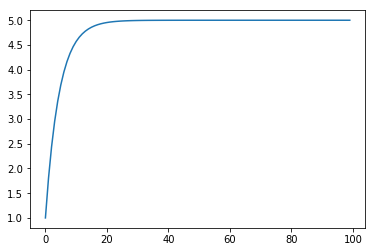

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
streak = []
curr = 0
for i in range(0,100):
    curr = 0.8*curr + 1
    streak.append(curr)

plt.plot(streak)

Here the max streak is 5 that can be achieved by around 30 continuous wins. However I'm going to linearly decrease the streak when a game is lost. 
Note the arbitrary nature of the decay function and streak increase/decrease. I don't need to get the function exactly right.

The machine learning algorithm will figure out the importance to give to the streak.

Now let's just add streaks and precompute for the existing set of data

In [56]:
df_cd['streak_A'] = 0.0
df_cd['streak_B'] = 0.0
df_cd['streak_AB'] = 0.0
df_cd['streak_BA'] = 0.0


streak_matrix = [[float(0)] * mxsize for i in range(mxsize)]
total_streak = [float(0)] * mxsize

In [57]:
for index, row in df_cd.iterrows():
    winner = row['Winner_id']
    teamA = row['Team_A_id']
    teamB = row['Team_B_id']
    
    df_cd.at[index, 'streak_AB'] = streak_matrix[teamA][teamB]
    df_cd.at[index, 'streak_BA'] = streak_matrix[teamB][teamA]
    
    loser = teamA
    if winner == teamA:
        loser = teamB
         
    df_cd.at[index, 'streak_A'] = total_streak[teamA]
    df_cd.at[index, 'streak_B'] = total_streak[teamB]     
    
    streak_matrix[loser][winner] = streak_matrix[loser][winner] - 0.5
    streak_matrix[winner][loser] = 0.8 * (streak_matrix[winner][loser]) + 1
    
    total_streak[loser] = total_streak[loser] - 0.5
    total_streak[winner] = 0.8*(total_streak[winner]) + 1
    

In [58]:
df_cd.head()

,Date,Ground,Team_A,Team_B,Winner,City,Host,Team_A_id,Team_B_id,Winner_id,Host_id,streak_A,streak_B,streak_AB,streak_BA
0,2000-01-02,Eden Park,New Zealand,West Indies,New Zealand,Auckland,New Zealand,0,7,0,0,0.00,0.0,0.00,0.0
37,2000-01-04,Owen Delany Park,New Zealand,West Indies,New Zealand,Taupo,New Zealand,0,7,0,0,1.00,-0.5,1.00,-0.5
39,2000-01-06,McLean Park,New Zealand,West Indies,New Zealand,Napier,New Zealand,0,7,0,0,1.80,-1.0,1.80,-1.0
67,2000-01-08,Westpac Stadium,New Zealand,West Indies,New Zealand,Wellington,New Zealand,0,7,0,0,2.44,-1.5,2.44,-1.5
98,2000-01-09,Brisbane Cricket Ground,Australia,Pakistan,Pakistan,Brisbane,Australia,1,5,5,1,0.00,0.0,0.00,0.0


In [59]:
#Checkpoint
joblib.dump(df_cd, '/home/sridhar/testcrick.jlb')

['/home/sridhar/testcrick.jlb']

Now that we have the data. Let's run a typical xgboost fit to figure out the winning team

In [93]:
full_df = df_cd[['Team_A_id', 'Team_B_id', 'Host_id', 'streak_A', 'streak_B', 'streak_AB', 'streak_BA', 'Winner_id']]
#Checkpoint
joblib.dump(full_df, '/home/sridhar/testcrick_df.jlb')
X = full_df[['Team_A_id', 'Team_B_id', 'Host_id', 'streak_A', 'streak_B', 'streak_AB', 'streak_BA']]
Y = full_df['Winner_id']

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.10)

In [94]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

In [98]:
clf = xgb()
grid_values = {'learning_rate': [.05, .1, .2],
               'n_estimators': [1000],
               'num_class': [mxsize],
               'max_depth': [10],
               'n_jobs': [10],
               'verbosity': [0],
               'objective': ['multi:softmax']}
grid_clf_auc = GridSearchCV(
                clf,
                param_grid=grid_values,
                n_jobs=10,
                verbose=True)
fit_model = grid_clf_auc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/sridhar/PE_CSV/malenv3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/sridhar/PE_CSV/malenv3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   9 out of   9 | elapsed:   20.5s finished


In [96]:
grid_clf_auc

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [1000], 'num_class': [23], 'max_depth': [10], 'n_jobs': [10], 'verbosity': [2], 'objective': ['multi:softmax']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [91]:
grid_clf_auc.best_params_

{'learning_rate': 0.05,
 'max_depth': 10,
 'n_estimators': 1000,
 'n_jobs': 10,
 'num_class': 23,
 'objective': 'multi:softmax',
 'verbosity': 2}

In [97]:
prediction = grid_clf_auc.predict(X_train_scaled)
proba = grid_clf_auc.predict_proba(X_train_scaled)
mistakes = 0
for y, i, j in zip(y_train, prediction,proba):
    if y != i:
        mistakes += 1
        
total_cases = len(y_train)
correct_pred = total_cases - mistakes
print("Accuracy on train set: {}/{}={}".format(correct_pred, total_cases, float(correct_pred)/total_cases))


prediction = grid_clf_auc.predict(X_test_scaled)
proba = grid_clf_auc.predict_proba(X_test_scaled)
mistakes = 0
for y, i, j in zip(y_test, prediction,proba):
    if y != i:
        mistakes += 1
        
total_cases = len(y_test)
correct_pred = total_cases - mistakes
print("Accuracy on test set: {}/{}={}".format(correct_pred, total_cases, float(correct_pred)/total_cases))

Accuracy on train set: 2288/2288=1.0
Accuracy on test set: 171/255=0.6705882352941176


So, what's happening here?
The model is overfitting the training data, and giving around 67% accuracy on the test data. 

Not a great model.. but meh.. I don't expect a high accuracy on this model because the inputs are highly subjective. If I just win 70% of the game prediction, I'm fine. (Given that I don't know much about the game to start with).

** Ended up getting 87% prediction on the World Cup Cricket series :)

We can now add helper functions to just checkpoint our solution, and update the streaks to generate updated predictions.
This is going to be helpful when predicting matches in a series.

In [69]:
#checkpoint
def checkpoint():
    global teams
    global scaler
    global grid_clf_auc
    global streak_matrix
    global total_streak
    global full_df
    joblib.dump(full_df, '/home/sridhar/crick/testcrick_df.jlb')
    joblib.dump(teams, '/home/sridhar/crick/teams.jlb')

    joblib.dump(scaler, '/home/sridhar/crick/scaler.jlb')

    joblib.dump(grid_clf_auc, '/home/sridhar/crick/grid_clf_auc.jlb')

    joblib.dump(streak_matrix, '/home/sridhar/crick/streak_matrix.jlb')

    joblib.dump(total_streak, '/home/sridhar/crick/total_streak.jlb')


In [70]:
def load_checkpoint():
    global teams
    global scaler
    global grid_clf_auc
    global streak_matrix
    global total_streak
    global full_df
    full_df = joblib.load('/home/sridhar/crick/testcrick_df.jlb')
    teams = joblib.load('/home/sridhar/crick/teams.jlb')

    scaler = joblib.load('/home/sridhar/crick/scaler.jlb')

    grid_clf_auc = joblib.load('/home/sridhar/crick/grid_clf_auc.jlb')

    streak_matrix = joblib.load('/home/sridhar/crick/streak_matrix.jlb')

    total_streak = joblib.load('/home/sridhar/crick/total_streak.jlb')


In [71]:
def print_update_prediction(teamA, teamB, host = None, winnername = None):
    global teams
    global scaler
    global grid_clf_auc
    global streak_matrix
    global total_streak
    if host is None:
        host = 'England'
    mydf = pd.DataFrame([[teamA, teamB, host]], columns=['Team_A', 'Team_B', 'Host'])
    mydf['Team_A_id'] = mydf['Team_A'].apply(lambda x: teams[teams == x].index[0])
    mydf['Team_B_id'] = mydf['Team_B'].apply(lambda x: teams[teams == x].index[0])
    mydf['Host_id'] = mydf['Host'].apply(lambda x: teams[teams == x].index[0])
    mydf['streak_A'] = 0.0
    mydf['streak_B'] = 0.0
    mydf['streak_AB'] = 0.0
    mydf['streak_BA'] = 0.0
    winnername = None
    for index, row in mydf.iterrows():
        teamA = row['Team_A_id']
        teamB = row['Team_B_id']
    
        mydf.at[index, 'streak_AB'] = streak_matrix[teamA][teamB]
        mydf.at[index, 'streak_BA'] = streak_matrix[teamB][teamA]
         
        mydf.at[index, 'streak_A'] = total_streak[teamA]
        mydf.at[index, 'streak_B'] = total_streak[teamB]
        if winnername is not None:
            winner = teams[teams == winnername].index[0]
            loser = teamA
            if winner == teamA:
                loser = teamB
            
            streak_matrix[loser][winner] = streak_matrix[loser][winner] - 0.5
            streak_matrix[winner][loser] = 0.8 * (streak_matrix[winner][loser]) + 1
    
            total_streak[loser] = total_streak[loser] - 0.5
            total_streak[winner] = 0.8*(total_streak[winner]) + 1
    mydf2 = mydf[['Team_A_id', 'Team_B_id', 'Host_id', 'streak_A', 'streak_B', 'streak_AB', 'streak_BA']]
    mydf_scaled = scaler.transform(mydf2.values)
    prediction_t = grid_clf_auc.predict(mydf_scaled)
    proba_t = grid_clf_auc.predict_proba(mydf_scaled)

    for i, j in zip(prediction_t,proba_t):
        print("{}, {}".format(teams[i],j[i]))

### Prediction
Now you could simply predict the game and even provide the winner name back to update the streak and generate the name of the winner with probability score.

In [72]:
print_update_prediction('Australia','Afghanistan', host = 'England')

Australia, 0.9750151038169861


In [73]:
print_update_prediction('India','Australia', host='India') 

India, 0.6103534698486328


In [74]:
print_update_prediction('India','Australia', host='Australia') 

India, 0.5572055578231812
